In [34]:
import pandas as pd
import urllib.parse
def decode_url_and_remove_HTTPversion(encoded_url:str) -> str:
    return urllib.parse.unquote(str(encoded_url)).replace(" HTTP/1.1","").replace("GET /","/")
dataFrame:pd.DataFrame = pd.read_csv('./data/access.csv')
'''
66.249.66.194  : Google crawler
66.249.66.91   : Google crawler but there is no access url under /browse or /product
151.239.241.163: May be employee(there is many request to upload image endpoint)
66.249.66.92   : Google crawler but there is no access url under /browse or /product
91.99.30.32    : may be employee
104.222.32.91  : Scanning? This ip hosts Cloud and domain system website.
91.99.72.15    : Scanning? internet service provider
91.99.47.57    :employee
'''
print(len(dataFrame))
dataFrame=dataFrame[dataFrame['IP']=='91.99.47.57']
print(len(dataFrame))
dataFrame = dataFrame[dataFrame['Referer'] != '-']
print(len(dataFrame))
dataFrame['Request']=dataFrame['Request'].apply(decode_url_and_remove_HTTPversion)
print(len(dataFrame))
dataFrame = dataFrame[dataFrame['Request'].str.contains('/browse/|/product/')]
print(len(dataFrame))
dataFrame = dataFrame[~dataFrame['Request'].str.match(r'^(/image|/product/image)')]
print(len(dataFrame))
dataFrame['Request'] = dataFrame['Request'].apply(lambda url: url.split('/')[-1])
print(len(dataFrame))
dataFrame=dataFrame[dataFrame['Request']!='']
print(len(dataFrame))
dataFrame['next_request'] = dataFrame.groupby('IP')['Request'].shift(-1)
print(len(dataFrame))
dataFrame = dataFrame.dropna(subset=['next_request'])
print(len(dataFrame))

10364149
38612
37784
37784
1680
1122
1122
1119
1119
1118


Access count:1118


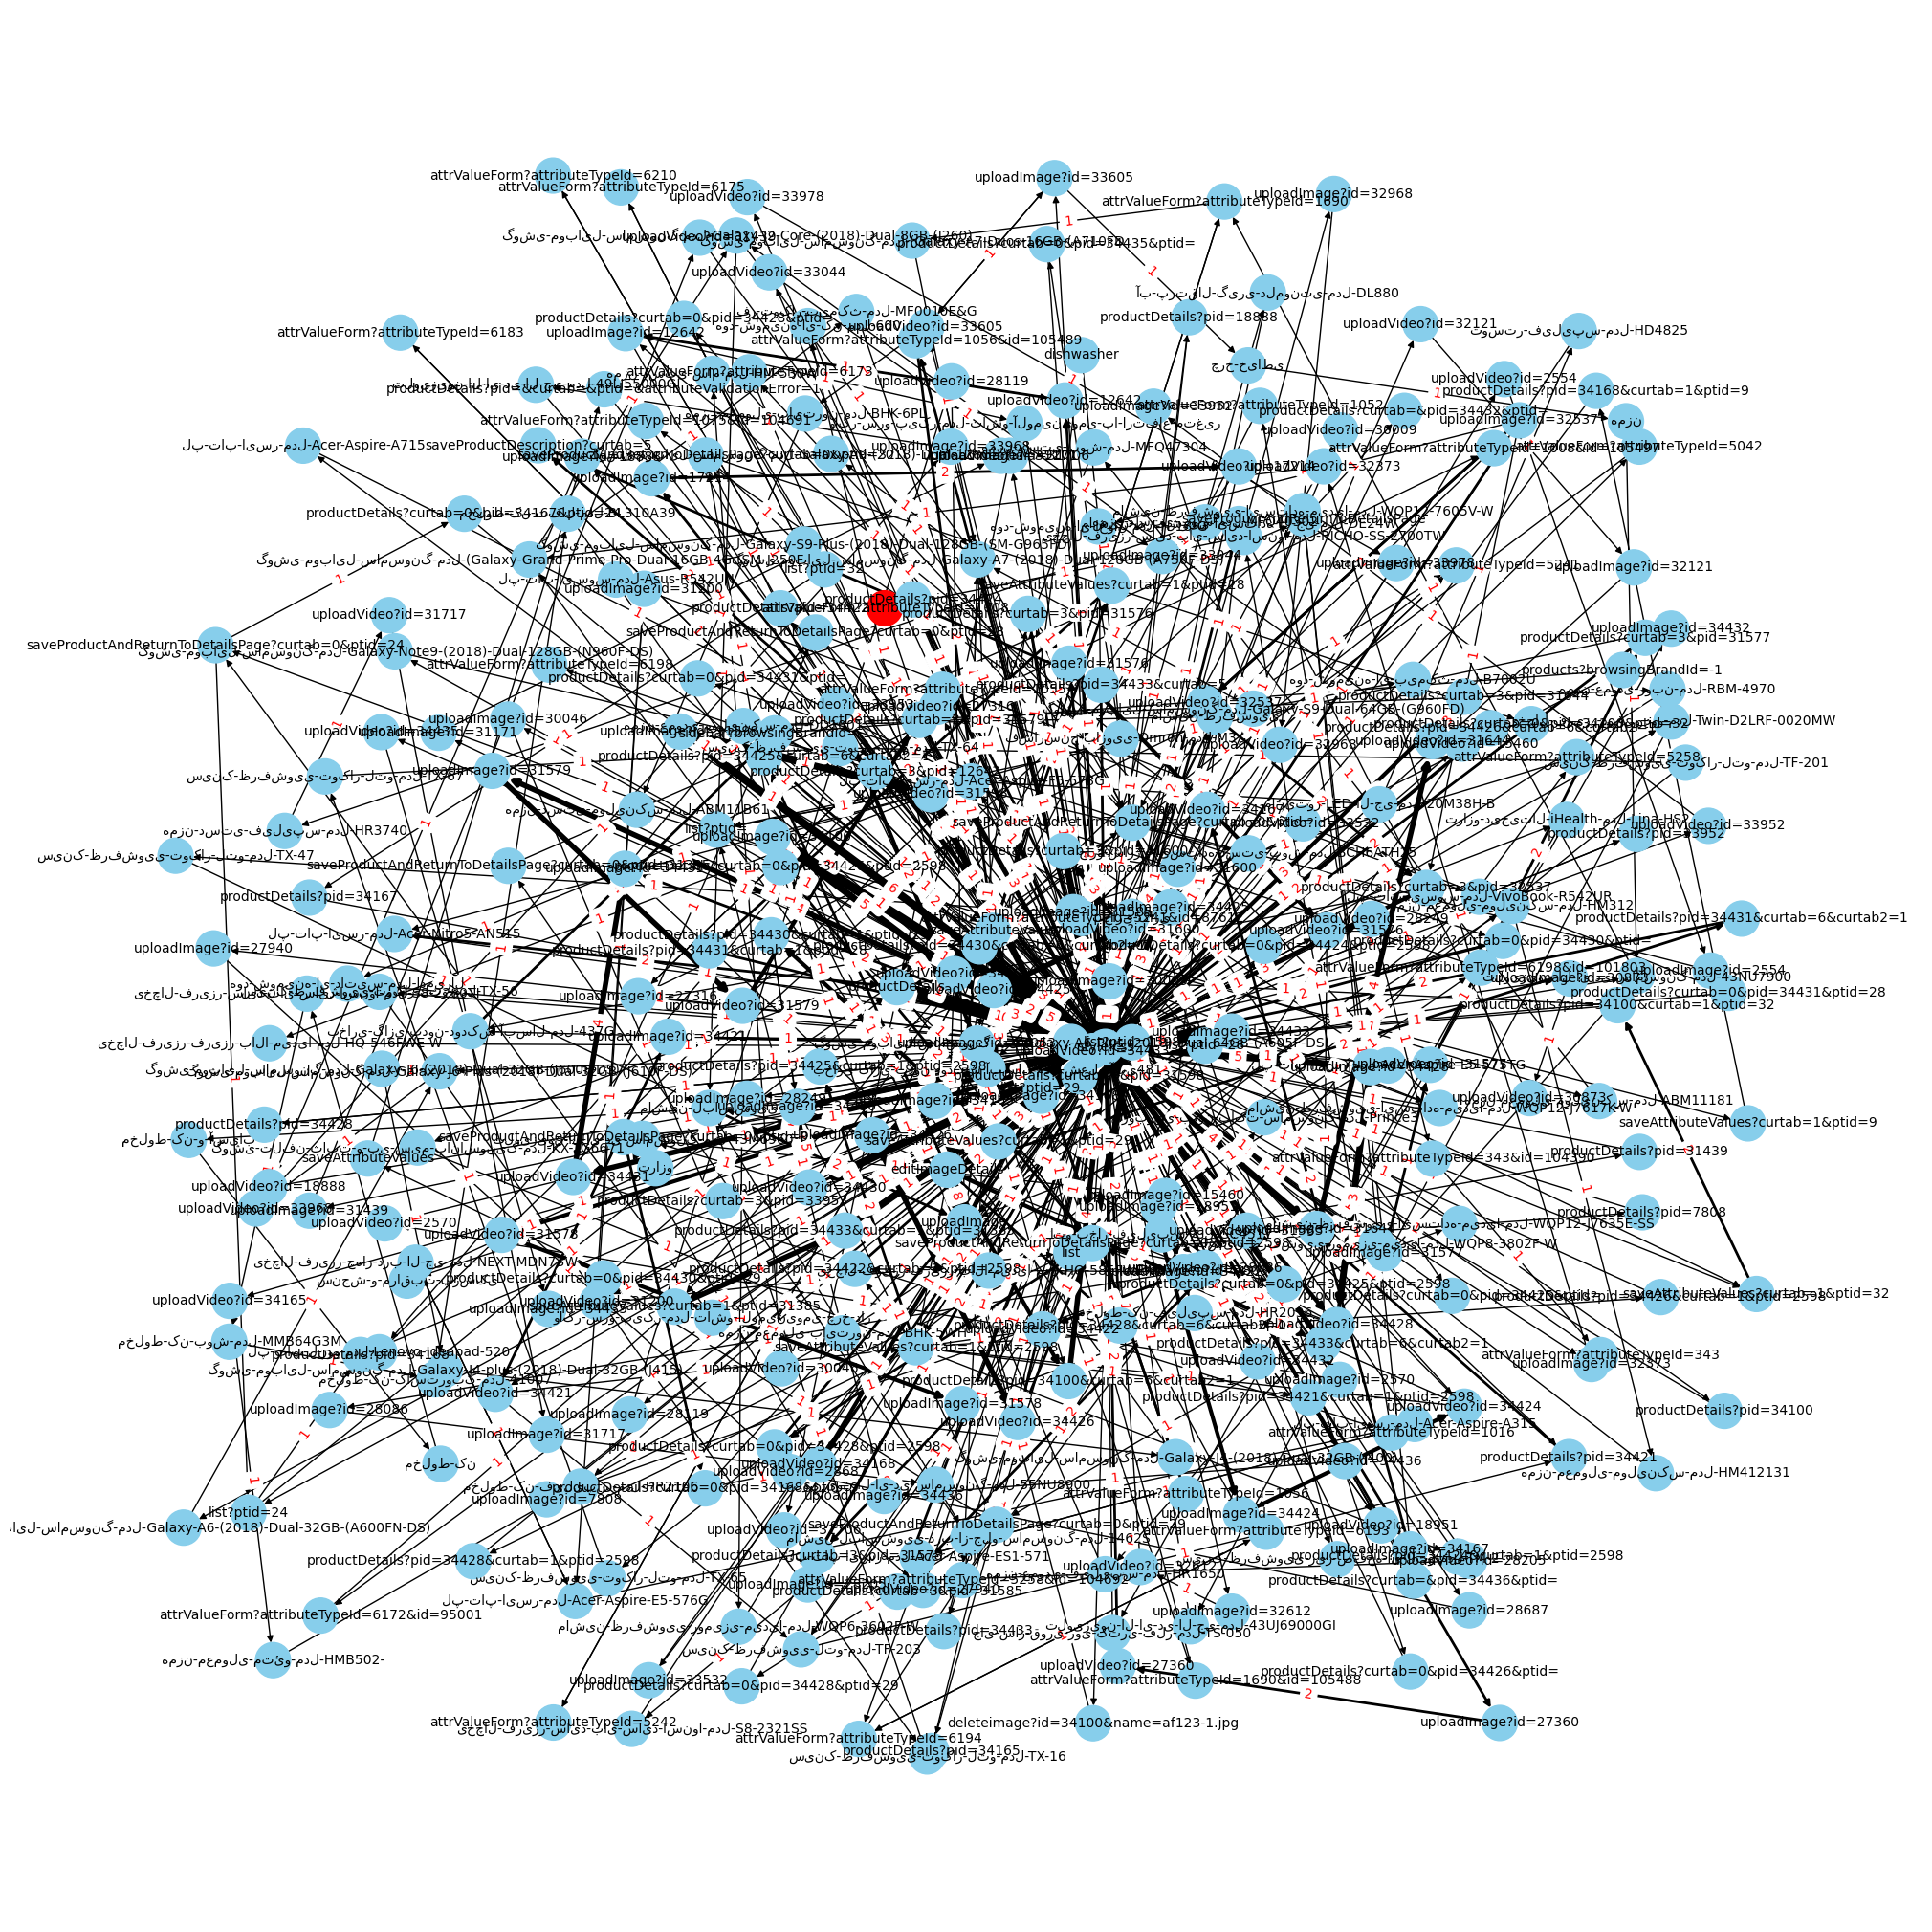

In [33]:
# 学習、予測
import networkx as nx
import matplotlib.pyplot as plt
import time
'''
start_time_ns = time.perf_counter_ns()
end_time_ns = time.perf_counter_ns()
print(f"Graph creation took {end_time_ns - start_time_ns} nanoseconds")
'''

# エッジのリストを作成し、遷移の数をカウント
transition_counts = dataFrame.groupby(
    ['Request', 'next_request']).size().reset_index(name='count')
# グラフを作成し、エッジの属性として遷移の数を格納
G = nx.DiGraph()
# ノードの色を設定するための辞書を初期化
node_colors = {}
# 最初のノードに特別な色を設定
first_node = True
for _, row in transition_counts.iterrows():
    if row['Request'] != row['next_request']:
        if first_node:
            node_colors[row['Request']] = 'red'
            first_node = False
        else:
            node_colors[row['Request']] = 'skyblue'
        G.add_edge(row['Request'], row['next_request'], weight=row['count'])
        # すべてのノードに色が割り当てられていることを確認
for node in G.nodes():
    if node not in node_colors:
        node_colors[node] = 'skyblue'
# グラフを描画する際に、エッジの太さを遷移の数に応じて設定
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G, k=0.13, iterations=5)
edge_widths = [G[u][v]['weight'] for u, v in G.edges()]
# エッジのラベルとして遷移のカウントを設定
edge_labels = {(u, v): G[u][v]['weight'] for u, v in G.edges()}
# ノードの色リストを作成
node_color_list = [node_colors[node] for node in G.nodes()]
nx.draw(G, pos, with_labels=True, node_size=700, node_color=node_color_list, font_size=10, width=edge_widths)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
print(f"Access count:{len(dataFrame)}")
plt.show()
